In [1]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 26.7 MB 12.5 MB/s eta 0:00:01   |███                             | 2.5 MB 7.8 MB/s eta 0:00:04
     |████████████████████████████████| 306 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 39.3 MB 10.8 MB/s eta 0:00:01     |█████████▋                      | 11.8 MB 15.2 MB/s eta 0:00:02     |█████████████▋                  | 16.7 MB 10.4 MB/s eta 0:00:03     |███████████████████████▍        | 28.7 MB 11.5 MB/s eta 0:00:01     |████████████████████████        | 29.3 MB 11.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Discover how to develop a deep convolutional neural network model from scratch for the CIFAR-10 object classification dataset.

Point to cover:

- CIFAR-10 Photo Classification Dataset
- Model Evaluation Test Harness
- How to Develop a Baseline Model
- How to Develop an Improved Model
- How to Develop Further Improvements
- How to Finalize the Model and Make Predictions


- How to develop a test harness to develop a robust evaluation of a model and establish a baseline of performance for a classification task.
- How to explore extensions to a baseline model to improve learning and model capacity.
- How to develop a finalized model, evaluate the performance of the final model, and use it to make predictions on new images.

## 1. CIFAR-10 Photo Classification Dataset

CIFAR is an acronym that stands for the "Canadian Institute For Advanced Research" and the CIFAR-10 dataset was developed along with the CIFAR-100 dataset by researchers at the CIFAR institute.

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, etc. The class labels and their standard associated integer values are listed below.

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck

These are very small images, much smaller than a typical photograph, and the dataset was intended for computer vision research.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


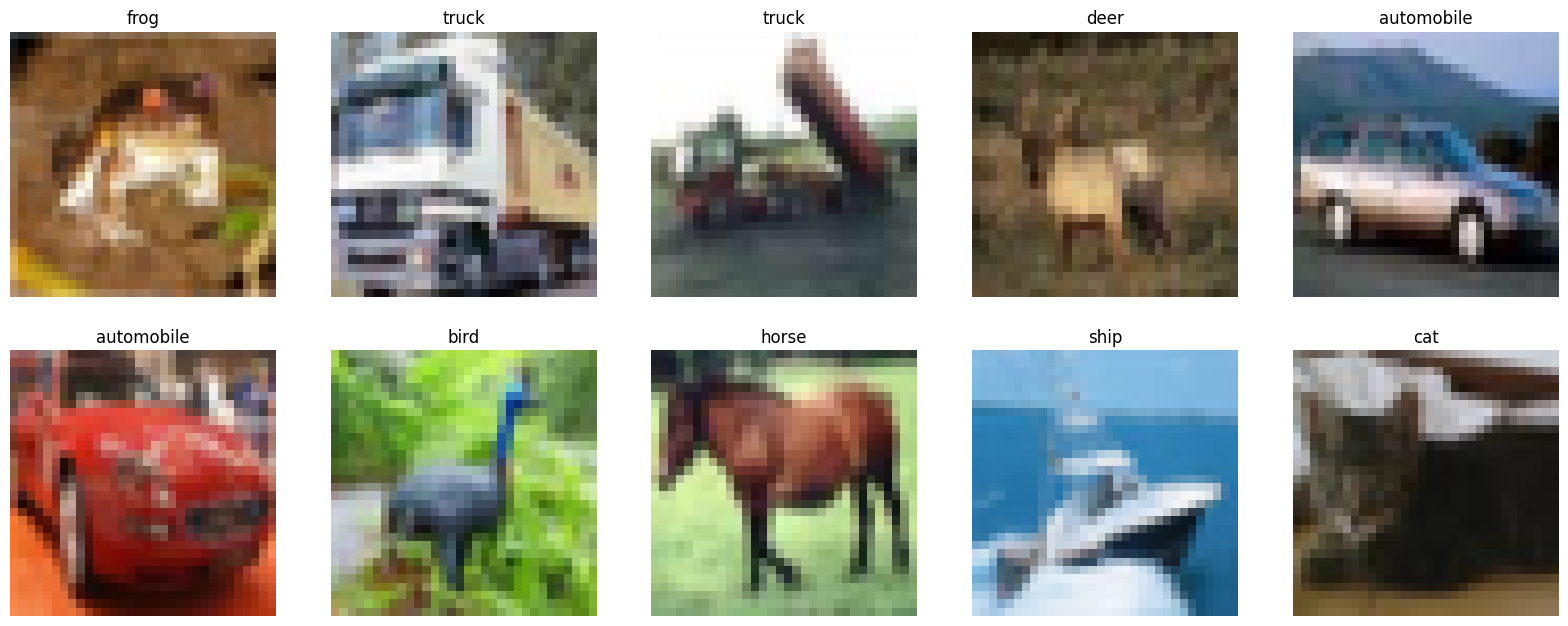

In [1]:
# example of loading the cifar10 dataset
import matplotlib.pyplot as plt
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# plot first few images
plt.figure(figsize=(20,20))
for i in range(10):
    # define subplot 
    ax = plt.subplot(5,5,i+1)
    # plot raw pixel data
    plt.imshow(trainX[i])
    plt.title(CLASS_NAMES[trainy[i][0]])
    plt.axis('off')
# show the figure
plt.show()

#### This low resolution is likely the cause of the limited performance that top-of-the-line algorithms are able to achieve on the dataset.

## 2.Model Evaluation Test Harness

We can develop this test harness with five key elements. They are :
- loading of the dataset
- preparation of the dataset
- definition of the model
- evaluation of the model
- presentation of results.

In [2]:
# test harness for evaluating models on the cifar10 dataset
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    trainX, valX, trainY, valY = train_test_split(trainX, trainY,
                                                  test_size= 0.2,
                                                  shuffle=True,
                                                  random_state=42,
                                                  stratify=trainY)
    # one hot encode target values
    trainY = to_categorical(trainY)
    valY = to_categorical(valY)
    testY = to_categorical(testY)
    
    print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
    print('Val: X=%s, y=%s' % (valX.shape, valY.shape))
    print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

    return trainX, trainY, valX, valY ,testX, testY

# scale pixels
def prep_pixels(train, val, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    val_norm = val.astype('float32')
    test_norm = test.astype('float32')
    
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    val_norm = val_norm / 255.0
    test_norm = test_norm / 255.0
    
    # return normalized images
    return train_norm, val_norm, test_norm


# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
#     figure, axes = plt.subplots(nrows=2, ncols=1) #build subplots.
    
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()    

    # save plot to file
    filename = "model_results"#sys.argv[0].split('/')[-1]
#     plt.savefig(filename + '_plot.png')
#     figure. tight_layout(pad=3.0)
    plt.show()
    plt.close()
    
def run_test_harness(epochs=50, batch_size=64):
    # load dataset
    trainX, trainY, valX, valY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, valX, testX = prep_pixels(trainX, valX, testX)
    # define model
    model = define_model()
    # fit model
    history = model.fit(trainX, trainY, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(valX, valY), 
                        verbose=1)
    print('-'*100)
    print("Evaluation on Test Set : ")
    loss, acc = model.evaluate(testX, testY, verbose=1)
    print('Test set Loss > %.3f' % (loss * 100.0))
    print('Test set Accuracy > %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)
    return model, history

ModuleNotFoundError: No module named 'sklearn'

## 3.How to Develop a Baseline Model
A good starting point is the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. 

For more details on the VGG model, see the 2015 paper “Very Deep Convolutional Networks for Large-Scale Image Recognition.”https://arxiv.org/abs/1409.1556

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.

**What to optimize** : The model will optimize the **categorical cross entropy loss function** required for multi-class classification and will monitor classification accuracy.

**How to optimize** : The model will be optimized using **stochastic gradient descent**.

**Hyperparameters for optimization** : We will use a modest **learning rate of 0.001** and a **large momentum of 0.9**, both of which are good general starting points.

In a 3-block VGG-style architecture

part1 : feature detector part of the model. 

part2 : classifier part of the model that interprets the features and makes a prediction as to which class a given photo belongs.

In [9]:
# Baseline: 1 VGG Block

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
625/625 [==============================] - 9s 9ms/step - loss: 1.8571 - accuracy: 0.3408 - val_loss: 1.6368 - val_accuracy: 0.4213
Epoch 2/50
625/625 [==============================] - 5s 8ms/step - loss: 1.5139 - accuracy: 0.4648 - val_loss: 1.4343 - val_accuracy: 0.4902
Epoch 3/50
625/625 [==============================] - 5s 9ms/step - loss: 1.3527 - accuracy: 0.5228 - val_loss: 1.3231 - val_accuracy: 0.5362
Epoch 4/50
625/625 [==============================] - 5s 8ms/step - loss: 1.2390 - accuracy: 0.5671 - val_loss: 1.2312 - val_accuracy: 0.5692
Epoch 5/50
625/625 [==============================] - 5s 9ms/step - loss: 1.1531 - accuracy: 0.5940 - val_loss: 1.2007 - val_accuracy: 0.5827
Epoch 6/50
625/625 [==============================] - 5s 9ms/step - loss: 1.0829 - accuracy: 0.6229 - val_loss: 1.1972 - val_accuracy: 0.5823
Epoch 7/50
625/625 [==============================] - 5s 8ms/step - loss: 1.0213 - accuracy: 0.6420 - val_loss: 1.1230 - val_accuracy: 0.6123
Epoch 

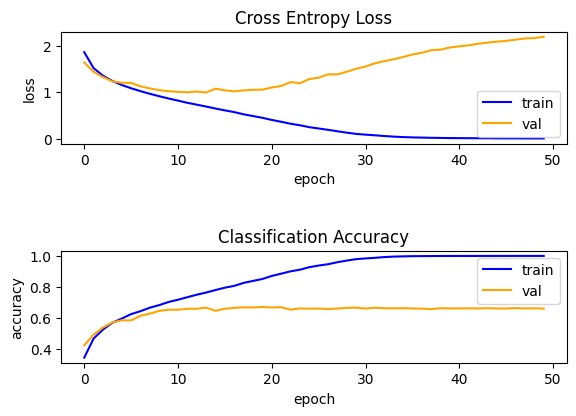

In [6]:
# entry point, run the test harness with 1 VGG block
model, history = run_test_harness(epochs=50, batch_size=64)

In this case, we can see that the model achieved a classification accuracy of just less than 70%.

From plots,we can see that the model rapidly overfits the test dataset.
This is clear if we look at the plot of loss (top plot), we can see that the model’s performance on the training dataset (blue) continues to improve whereas the performance on the test dataset (orange) improves, then starts to get worse at around 15 epochs.


In [10]:
# Baseline: 2 VGG Blocks
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
625/625 [==============================] - 8s 12ms/step - loss: 1.8022 - accuracy: 0.3548 - val_loss: 1.5696 - val_accuracy: 0.4325
Epoch 2/50
625/625 [==============================] - 7s 11ms/step - loss: 1.4533 - accuracy: 0.4802 - val_loss: 1.3691 - val_accuracy: 0.5100
Epoch 3/50
625/625 [==============================] - 7s 11ms/step - loss: 1.3048 - accuracy: 0.5364 - val_loss: 1.2296 - val_accuracy: 0.5630
Epoch 4/50
625/625 [==============================] - 7s 10ms/step - loss: 1.1897 - accuracy: 0.5799 - val_loss: 1.1668 - val_accuracy: 0.5903
Epoch 5/50
625/625 [==============================] - 7s 11ms/step - loss: 1.0988 - accuracy: 0.6121 - val_loss: 1.1738 - val_accuracy: 0.5873
Epoch 6/50
625/625 [==============================] - 7s 11ms/step - loss: 1.0206 - accuracy: 0.6424 - val_loss: 1.0377 - val_accuracy: 0.6386
Epoch 7/50
625/625 [==============================] - 7s 10ms/step - loss: 0.9491 - accuracy: 0.6673 - val_loss: 1.0205 - val_accuracy: 0.6399

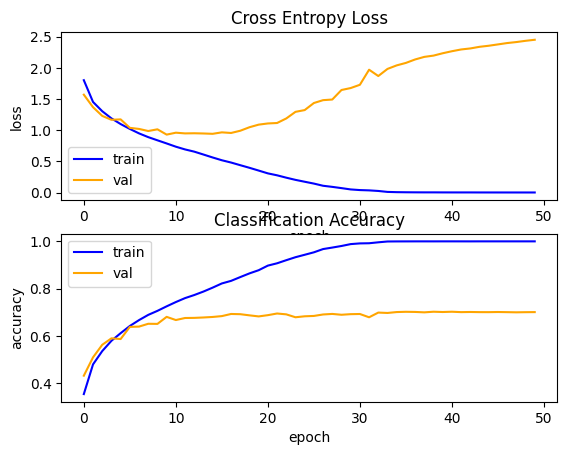

In [11]:
# entry point, run the test harness with 2 VGG blocks
model, history = run_test_harness(epochs=50, batch_size=64)

In this case, we can see that the model with two blocks performs better than the model with a single block: a good sign. we got 70% accuracy on test set
From plots, we continue to see strong overfitting.

In [13]:
# Baseline: 3 VGG Blocks

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
625/625 [==============================] - 9s 14ms/step - loss: 1.7746 - accuracy: 0.3590 - val_loss: 1.5353 - val_accuracy: 0.4454
Epoch 2/50
625/625 [==============================] - 8s 13ms/step - loss: 1.4428 - accuracy: 0.4826 - val_loss: 1.3926 - val_accuracy: 0.4990
Epoch 3/50
625/625 [==============================] - 8s 13ms/step - loss: 1.2978 - accuracy: 0.5379 - val_loss: 1.3153 - val_accuracy: 0.5290
Epoch 4/50
625/625 [==============================] - 8s 13ms/step - loss: 1.1729 - accuracy: 0.5854 - val_loss: 1.2142 - val_accuracy: 0.5668
Epoch 5/50
625/625 [==============================] - 8s 12ms/step - loss: 1.0743 - accuracy: 0.6205 - val_loss: 1.1087 - val_accuracy: 0.6091
Epoch 6/50
625/625 [==============================] - 8s 13ms/step - loss: 0.9838 - accuracy: 0.6532 - val_loss: 1.0462 - val_accuracy: 0.6319
Epoch 7/50
625/625 [==============================] - 8s 13ms/step - loss: 0.8986 - accuracy: 0.6843 - val_loss: 1.0580 - val_accuracy: 0.6347

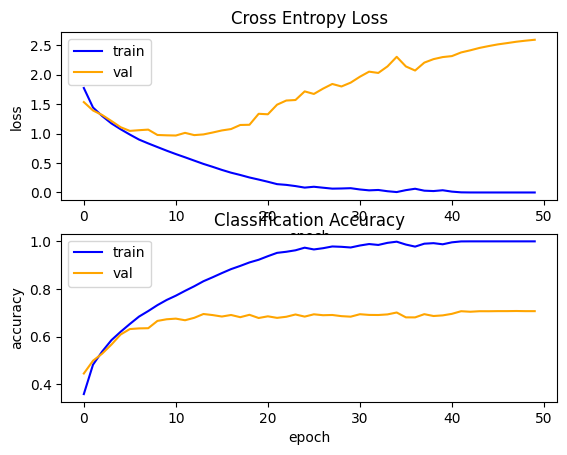

In [14]:
# entry point, run the test harness with 3 VGG blocks
model, history = run_test_harness(epochs=50, batch_size=64)

again we see dramatic overfitting within the first 20 training epochs.

## SUMMARY
We have explored three different models with a VGG-based architecture.

The results can be summarized below, although we must assume some variance in these results given the stochastic nature of the algorithm:

**VGG 1: 65.400%**

**VGG 2: 70.090%**

**VGG 3: 70.270%**

In all cases, the model was able to learn the training dataset, showing an improvement on the training dataset that at least continued to 50 epochs, and perhaps more. This is a good sign, as it shows that the problem is learnable and that all three models have sufficient capacity to learn the problem.

These results suggest that the model with three VGG blocks is a good starting point or baseline model for our investigation.

The results also suggest that the model is in need of regularization to address the rapid overfitting of the test dataset. More generally, the results suggest that it may be useful to investigate techniques that slow down the convergence (rate of learning) of the model. This may include techniques such as data augmentation as well as learning rate schedules, changes to the batch size, and perhaps more.

## 4.How to Develop an Improved Model
Now that we have established a baseline model, the VGG architecture with three blocks, we can investigate modifications to the model and the training algorithm that seek to improve performance.

We will look at two main areas first to address the severe overfitting observed, namely regularization and data augmentation.

### Regularization Techniques
There are many regularization techniques we could try, although the nature of the overfitting observed suggests that perhaps early stopping would not be appropriate and that techniques that slow down the rate of convergence might be useful.

We will look into the effect of both dropout and weight regularization or weight decay.

>   **Dropout Regularization**
     Dropout is a simple technique that will randomly drop nodes out of the network. It has a regularizing effect as the remaining nodes must adapt to pick-up the slack of the removed nodes.
     
     Dropout can be added to the model by adding new Dropout layers, where the amount of nodes removed is specified as a parameter.
     In this case, we will add Dropout layers after each max pooling layer and after the fully connected layer, and use a fixed dropout rate of 20% (e.g. retain 80% of the nodes).
     
>    **Weight Decay**
    Weight regularization or weight decay involves updating the loss function to penalize the model in proportion to the size of the model weights.     
    This has a regularizing effect, as larger weights result in a more complex and less stable model, whereas smaller weights are often more stable and more general.
    
    We can add weight regularization to the convolutional layers and the fully connected layers by defining the “kernel_regularizer” argument and specifying the type of regularization. In this case, we will use L2 weight regularization, the most common type used for neural networks and a sensible default weighting of 0.001.

In [18]:
# The updated VGG 3 baseline model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
625/625 [==============================] - 10s 15ms/step - loss: 2.0705 - accuracy: 0.2249 - val_loss: 1.7470 - val_accuracy: 0.3773
Epoch 2/50
625/625 [==============================] - 8s 13ms/step - loss: 1.7132 - accuracy: 0.3675 - val_loss: 1.5559 - val_accuracy: 0.4344
Epoch 3/50
625/625 [==============================] - 9s 14ms/step - loss: 1.5799 - accuracy: 0.4181 - val_loss: 1.5188 - val_accuracy: 0.4456
Epoch 4/50
625/625 [==============================] - 9s 14ms/step - loss: 1.4770 - accuracy: 0.4572 - val_loss: 1.3672 - val_accuracy: 0.5121
Epoch 5/50
625/625 [==============================] - 8s 13ms/step - loss: 1.4054 - accuracy: 0.4850 - val_loss: 1.2749 - val_accuracy: 0.5389
Epoch 6/50
625/625 [==============================] - 8s 13ms/step - loss: 1.3345 - accuracy: 0.5150 - val_loss: 1.2375 - val_accuracy: 0.5600
Epoch 7/50
625/625 [==============================] - 8s 13ms/step - loss: 1.2760 - accuracy: 0.5397 - val_loss: 1.1575 - val_accuracy: 0.583

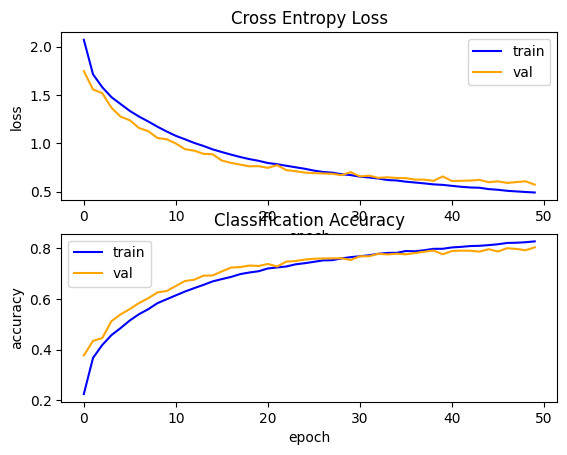

In [19]:
# entry point, run the test harness with Dropout(0.2)
model, history = run_test_harness(epochs=50, batch_size=64)

In this case, we can see a jump in classification accuracy by about 10% from about **70.27% without dropout** to about **80.23% with dropout**.

From the learning curve for the model, we can see that overfitting has been addressed. The model converges well for about 40 or 50 epochs.

This is a great result. We could elaborate upon this model and add early stopping with a patience of about 10 epochs to save a well-performing model on the test set during training at around the point that no further improvements are observed.

We could also try exploring a learning rate schedule that drops the learning rate after improvements on the test set stall.

Dropout has performed well, and we do not know that the chosen rate of 20% is the best. We could explore other dropout rates, as well as differing positioning of the dropout layers in the model architecture.

In [23]:
# updated baseline model with weight decay
# define cnn model
from keras.regularizers import l2

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     kernel_regularizer=l2(0.001)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
625/625 [==============================] - 10s 14ms/step - loss: 2.9561 - accuracy: 0.3424 - val_loss: 2.7547 - val_accuracy: 0.4061
Epoch 2/50
625/625 [==============================] - 8s 13ms/step - loss: 2.5765 - accuracy: 0.4760 - val_loss: 2.5217 - val_accuracy: 0.4980
Epoch 3/50
625/625 [==============================] - 8s 13ms/step - loss: 2.4083 - accuracy: 0.5296 - val_loss: 2.3915 - val_accuracy: 0.5391
Epoch 4/50
625/625 [==============================] - 8s 13ms/step - loss: 2.2729 - accuracy: 0.5747 - val_loss: 2.2901 - val_accuracy: 0.5665
Epoch 5/50
625/625 [==============================] - 8s 13ms/step - loss: 2.1611 - accuracy: 0.6087 - val_loss: 2.2128 - val_accuracy: 0.5922
Epoch 6/50
625/625 [==============================] - 8s 13ms/step - loss: 2.0504 - accuracy: 0.6437 - val_loss: 2.1272 - val_accuracy: 0.6114
Epoch 7/50
625/625 [==============================] - 8s 13ms/step - loss: 1.9614 - accuracy: 0.6693 - val_loss: 2.0525 - val_accuracy: 0.637

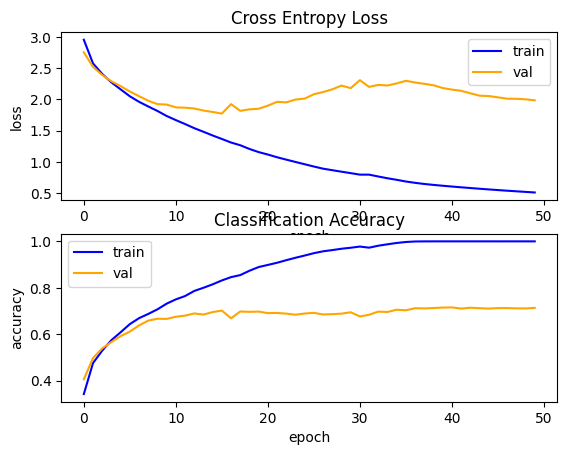

In [24]:
# entry point, run the test harness with weight decay 0.001
model, history = run_test_harness(epochs=50, batch_size=64)

In this case, we see minor improvement in the model performance on the test set, 70.27% to about 70.90% classification accuracy

Reviewing the learning curves, we do see a small reduction in the overfitting, but the impact is not as effective as dropout.

We might be able to improve the effect of weight decay by perhaps using a larger weighting, such as 0.01 or even 0.1.

In [25]:
# updated baseline model with weight decay 0.01
# define cnn model
from keras.regularizers import l2

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.01), input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.01)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     kernel_regularizer=l2(0.01)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
625/625 [==============================] - 9s 14ms/step - loss: 10.0317 - accuracy: 0.3586 - val_loss: 8.8113 - val_accuracy: 0.4666
Epoch 2/50
625/625 [==============================] - 8s 13ms/step - loss: 7.9856 - accuracy: 0.4779 - val_loss: 7.2199 - val_accuracy: 0.4906
Epoch 3/50
625/625 [==============================] - 8s 13ms/step - loss: 6.5322 - accuracy: 0.5224 - val_loss: 5.9671 - val_accuracy: 0.5253
Epoch 4/50
625/625 [==============================] - 9s 14ms/step - loss: 5.4129 - accuracy: 0.5561 - val_loss: 4.9637 - val_accuracy: 0.5578
Epoch 5/50
625/625 [==============================] - 8s 13ms/step - loss: 4.5525 - accuracy: 0.5763 - val_loss: 4.1890 - val_accuracy: 0.5939
Epoch 6/50
625/625 [==============================] - 8s 13ms/step - loss: 3.8795 - accuracy: 0.6009 - val_loss: 3.6415 - val_accuracy: 0.5868
Epoch 7/50
625/625 [==============================] - 8s 13ms/step - loss: 3.3533 - accuracy: 0.6162 - val_loss: 3.2167 - val_accuracy: 0.595

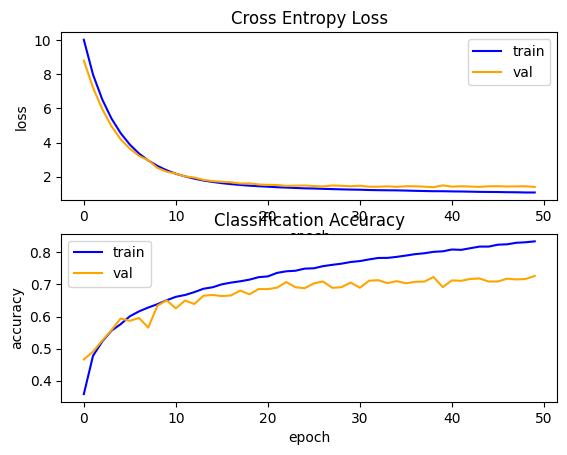

In [26]:
# entry point, run the test harness with weight decay 0.01
model, history = run_test_harness(epochs=50, batch_size=64)

In this case, we see 2% of improvement in the model performance on the test set, 70.27% to about 72.67% classification accuracy

From the learning curve for the model, we can see that overfitting has been addressed. The model converges well for about 40 or 50 epochs.

This is a great result. We could elaborate upon this model and add early stopping with a patience of about 10 epochs to save a well-performing model on the test set during training at around the point that no further improvements are observed.

We could also try exploring a learning rate schedule that drops the learning rate after improvements on the test set stall.

In [28]:
# updated baseline model with weight decay 0.1
# define cnn model
from keras.regularizers import l2

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.1), input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.1)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     kernel_regularizer=l2(0.1)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     kernel_regularizer=l2(0.1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
625/625 [==============================] - 9s 14ms/step - loss: 36.0484 - accuracy: 0.2670 - val_loss: 9.7411 - val_accuracy: 0.2573
Epoch 2/50
625/625 [==============================] - 8s 13ms/step - loss: 5.1099 - accuracy: 0.2730 - val_loss: 3.0319 - val_accuracy: 0.2746
Epoch 3/50
625/625 [==============================] - 8s 13ms/step - loss: 2.6617 - accuracy: 0.2653 - val_loss: 2.4997 - val_accuracy: 0.2633
Epoch 4/50
625/625 [==============================] - 8s 13ms/step - loss: 2.4390 - accuracy: 0.2641 - val_loss: 2.4311 - val_accuracy: 0.2555
Epoch 5/50
625/625 [==============================] - 8s 13ms/step - loss: 2.3870 - accuracy: 0.2639 - val_loss: 2.3719 - val_accuracy: 0.2749
Epoch 6/50
625/625 [==============================] - 8s 13ms/step - loss: 2.3637 - accuracy: 0.2673 - val_loss: 2.3594 - val_accuracy: 0.2736
Epoch 7/50
625/625 [==============================] - 8s 13ms/step - loss: 2.3543 - accuracy: 0.2697 - val_loss: 2.3512 - val_accuracy: 0.265

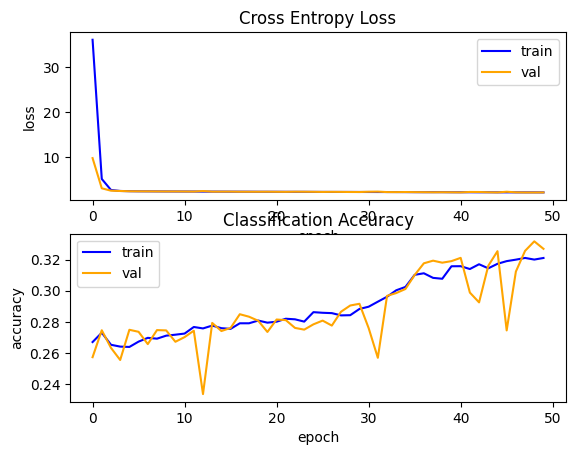

In [29]:
# entry point, run the test harness with weight decay 0.1
model, history = run_test_harness(epochs=50, batch_size=64)

In this case, we see there is drastic decrease in model performance.Model performance went down by weight decay with 0.1 rate.

### Data Augmentation

Data augmentation involves making copies of the examples in the training dataset with small random modifications.

This has a regularizing effect as it both expands the training dataset and allows the model to learn the same general features, although in a more generalized manner.

There are many types of data augmentation that could be applied. Given that the dataset is comprised of small photos of objects, we do not want to use augmentation that distorts the images too much, so that useful features in the images can be preserved and used.

The types of random augmentations that could be useful include:
    
    - a horizontal flip, 
    - minor shifts of the image
    - small zooming 
    - cropping of the image.
    
    We will investigate the effect of simple augmentation on the baseline image, specifically horizontal flips and 10% shifts in the height and width of the image.

In [5]:
# baseline model with data augmentation on the cifar10 dataset
from keras.preprocessing.image import ImageDataGenerator
# Baseline: 3 VGG Blocks

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def run_test_harness(epochs=50, batch_size=64):
    # load dataset
    trainX, trainY, valX, valY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, valX, testX = prep_pixels(trainX, valX, testX)
    
    # define model
    model = define_model()
    
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY, batch_size=batch_size)
    # fit model
#     steps = int(trainX.shape[0] / 64)
    
    history = model.fit_generator(it_train,
#                                   steps_per_epoch=steps, 
                                  epochs=epochs,
                                  validation_data=(valX, valY), 
                                  verbose=1)
    # evaluate model
    print('-'*100)
    print("Evaluation on Test Set : ")
    loss, acc = model.evaluate(testX, testY, verbose=1)
    print('Test set Loss > %.3f' % (loss * 100.0))
    print('Test set Accuracy > %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)
    return model, history

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-5-f35f2230e331>:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(it_train,


Epoch 1/50
625/625 [==============================] - 30s 43ms/step - loss: 1.8669 - accuracy: 0.3234 - val_loss: 1.6011 - val_accuracy: 0.4226
Epoch 2/50
625/625 [==============================] - 26s 42ms/step - loss: 1.5494 - accuracy: 0.4395 - val_loss: 1.4874 - val_accuracy: 0.4568
Epoch 3/50
625/625 [==============================] - 23s 37ms/step - loss: 1.4180 - accuracy: 0.4880 - val_loss: 1.3795 - val_accuracy: 0.5041
Epoch 4/50
625/625 [==============================] - 27s 43ms/step - loss: 1.3206 - accuracy: 0.5276 - val_loss: 1.2411 - val_accuracy: 0.5592
Epoch 5/50
625/625 [==============================] - 26s 41ms/step - loss: 1.2509 - accuracy: 0.5545 - val_loss: 1.1703 - val_accuracy: 0.5845
Epoch 6/50
625/625 [==============================] - 25s 41ms/step - loss: 1.1876 - accuracy: 0.5767 - val_loss: 1.0471 - val_accuracy: 0.6358
Epoch 7/50
625/625 [==============================] - 26s 41ms/step - loss: 1.1274 - accuracy: 0.6003 - val_loss: 1.0402 - val_accuracy:

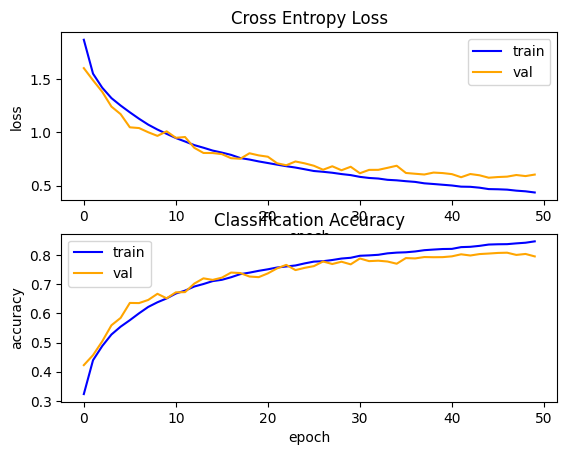

In [6]:
# entry point, run the test harness with data augmentation
model, history = run_test_harness(epochs=50, batch_size=64)

In this case, we see another large improvement in model performance, much like we saw with dropout. In this case, an improvement of about 9% from about 70% for the baseline model to about 78.9%.

Reviewing the learning curves, we see a similar improvement in model performances as we do with dropout.
The results suggest that perhaps a configuration that used both dropout and data augmentation might be effective.

## Summary
In this section, we explored three approaches designed to slow down the convergence of the model.

A summary of the results is provided below:

#### Baseline : 70.2%
#### Baseline + Dropout: 80.23%
#### Baseline + Weight Decay(0.001): 70.9%
#### Baseline + Weight Decay(0.01): 72.66%
#### Baseline + Weight Decay(0.1): 33.08%
#### Baseline + Data Augmentation: 78.9%

The results suggest that both dropout and data augmentation are having the desired effect, and weight decay with 0.01 has improved little performance.

Now that the model is learning well, we can look for both improvements on what is working, as well as combinations on what is working.

## 4.How to Develop Further Improvements

We will now investigate refinements of these techniques to see if we can further improve the model’s performance. Specifically, we will look at a variation of dropout regularization and combining dropout with data augmentation.

Learning has slowed down, so we will investigate increasing the number of training epochs to give the model enough space, if needed, to expose the learning dynamics in the learning curves.

### Variation of Dropout Regularization
Dropout is working very well, so it may be worth investigating variations of how dropout is applied to the model.

One variation that might be interesting is to increase the amount of dropout from 20% to 25% or 30%. Another variation that might be interesting is using a pattern of increasing dropout from 20% for the first block, 30% for the second block, and so on to 50% at the fully connected layer in the classifier part of the model.

This type of increasing dropout with the depth of the model is a common pattern. It is effective as it forces layers deep in the model to regularize more than layers closer to the input.

In [11]:
# define cnn model by applying dropout as 20% for the first block, 30% for the second block, and so on to 50%
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

def run_test_harness(epochs=50, batch_size=64):
    # load dataset
    trainX, trainY, valX, valY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, valX, testX = prep_pixels(trainX, valX, testX)
    # define model
    model = define_model()
    # fit model
    history = model.fit(trainX, trainY, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(valX, valY), 
                        verbose=1)
    print('-'*100)
    print("Evaluation on Test Set : ")
    loss, acc = model.evaluate(testX, testY, verbose=1)
    print('Test set Loss > %.3f' % (loss * 100.0))
    print('Test set Accuracy > %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)
    return model, history

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
625/625 [==============================] - 8s 12ms/step - loss: 2.2124 - accuracy: 0.1677 - val_loss: 2.1078 - val_accuracy: 0.2082
Epoch 2/100
625/625 [==============================] - 7s 12ms/step - loss: 1.9969 - accuracy: 0.2501 - val_loss: 1.8471 - val_accuracy: 0.3193
Epoch 3/100
625/625 [==============================] - 7s 12ms/step - loss: 1.8301 - accuracy: 0.3063 - val_loss: 1.7072 - val_accuracy: 0.3635
Epoch 4/100
625/625 [==============================] - 7s 12ms/step - loss: 1.7249 - accuracy: 0.3553 - val_loss: 1.5797 - val_accuracy: 0.4247
Epoch 5/100
625/625 [==============================] - 7s 12ms/step - loss: 1.6410 - accuracy: 0.3903 - val_loss: 1.5044 - val_accuracy: 0.4520
Epoch 6/100
625/625 [==============================] - 7s 12ms/step - loss: 1.5805 - accuracy: 0.4176 - val_loss: 1.4360 - val_accuracy: 0.4722
Epoch 7/100
625/625 [==============================] - 7s 12ms/step - loss: 1.5156 - accuracy: 0.4408 - val_loss: 1.3860 - val_accuracy:

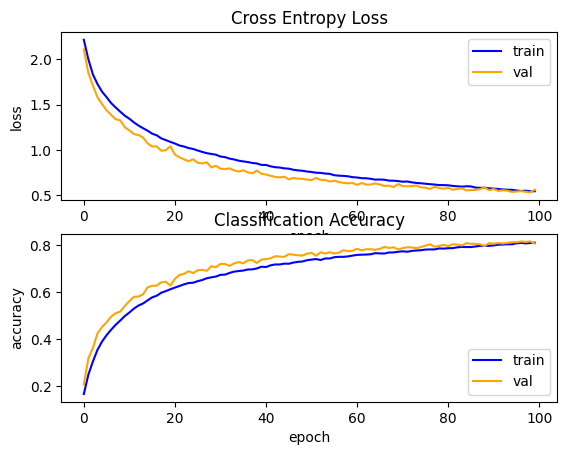

In [12]:
# entry point, run the test harness with Variation of Dropout and increased number of epochs
model, history = run_test_harness(epochs=100, batch_size=64)

In this case, we can see a small drop in performance from fixed dropout at about 80.3% to increasing dropout at about 79.99%. may be need to choose better dropout values.

Reviewing the learning curves, we can see that the model converges well, with performance on the val dataset. we can see that again the rate of learning has been further slowed, allowing further refinement of the model without overfitting.

This is a fruitful area for investigation on this model, and perhaps more dropout layers and/or more aggressive dropout may result in further improvements.

### Dropout and Data Augmentation
In the previous section, we discovered that both dropout and data augmentation resulted in a significant improvement in model performance.

In this section, we can experiment with combining both of these changes to the model to see if a further improvement can be achieved. Specifically, whether using both regularization techniques together results in better performance than either technique used alone.


In [13]:
# The updated VGG 3 baseline model with dropout of 0.2 in each block and data augmentation
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def run_test_harness(epochs=50, batch_size=64):
    # load dataset
    trainX, trainY, valX, valY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, valX, testX = prep_pixels(trainX, valX, testX)
    
    # define model
    model = define_model()
    
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY, batch_size=batch_size)
    # fit model
#     steps = int(trainX.shape[0] / 64)
    
    history = model.fit_generator(it_train,
#                                   steps_per_epoch=steps, 
                                  epochs=epochs,
                                  validation_data=(valX, valY), 
                                  verbose=1)
    # evaluate model
    print('-'*100)
    print("Evaluation on Test Set : ")
    loss, acc = model.evaluate(testX, testY, verbose=1)
    print('Test set Loss > %.3f' % (loss * 100.0))
    print('Test set Accuracy > %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)
    return model, history

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-13-828ae34711ab>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(it_train,


Epoch 1/100
625/625 [==============================] - 26s 41ms/step - loss: 2.1276 - accuracy: 0.2021 - val_loss: 1.9455 - val_accuracy: 0.3032
Epoch 2/100
625/625 [==============================] - 20s 32ms/step - loss: 1.8419 - accuracy: 0.3220 - val_loss: 1.6800 - val_accuracy: 0.3860
Epoch 3/100
625/625 [==============================] - 25s 39ms/step - loss: 1.7121 - accuracy: 0.3658 - val_loss: 1.5367 - val_accuracy: 0.4343
Epoch 4/100
625/625 [==============================] - 26s 42ms/step - loss: 1.6224 - accuracy: 0.4012 - val_loss: 1.4556 - val_accuracy: 0.4652
Epoch 5/100
625/625 [==============================] - 24s 38ms/step - loss: 1.5625 - accuracy: 0.4266 - val_loss: 1.4496 - val_accuracy: 0.4724
Epoch 6/100
625/625 [==============================] - 25s 40ms/step - loss: 1.5039 - accuracy: 0.4521 - val_loss: 1.3600 - val_accuracy: 0.5089
Epoch 7/100
625/625 [==============================] - 24s 39ms/step - loss: 1.4568 - accuracy: 0.4676 - val_loss: 1.3404 - val_ac

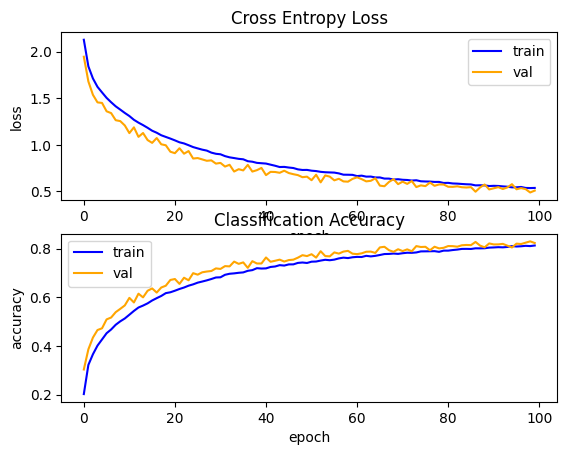

In [14]:
# The updated VGG 3 baseline model with dropout of 0.2 in each block and data augmentation
model, history = run_test_harness(epochs=100, batch_size=64)

In this case, we can see that as we would have hoped, using both regularization techniques together has resulted in a further lift in model performance on the test set. In this case, combining fixed dropout with about 80.23% and data augmentation with about 78.9% has resulted in an improvement to about 82.32% classification accuracy

Results might be further improved if a pattern of increasing dropout was used instead of a fixed dropout rate throughout the depth of the model.

In [19]:
# The updated VGG 3 baseline model with dropout of 0.2, 0.3, 0.4, 0.5 and data augmentation
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def run_test_harness(epochs=50, batch_size=64):
    # load dataset
    trainX, trainY, valX, valY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, valX, testX = prep_pixels(trainX, valX, testX)
    
    # define model
    model = define_model()
    
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY, batch_size=batch_size)
    # fit model
#     steps = int(trainX.shape[0] / 64)
    
    history = model.fit_generator(it_train,
#                                   steps_per_epoch=steps, 
                                  epochs=epochs,
                                  validation_data=(valX, valY), 
                                  verbose=1)
    # evaluate model
    print('-'*100)
    print("Evaluation on Test Set : ")
    loss, acc = model.evaluate(testX, testY, verbose=1)
    print('Test set Loss > %.3f' % (loss * 100.0))
    print('Test set Accuracy > %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)
    return model, history

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-19-903f42cd445e>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(it_train,


Epoch 1/100
625/625 [==============================] - 26s 40ms/step - loss: 2.2550 - accuracy: 0.1467 - val_loss: 2.1173 - val_accuracy: 0.2552
Epoch 2/100
625/625 [==============================] - 26s 41ms/step - loss: 2.0778 - accuracy: 0.2228 - val_loss: 1.9801 - val_accuracy: 0.2985
Epoch 3/100
625/625 [==============================] - 25s 40ms/step - loss: 1.9591 - accuracy: 0.2577 - val_loss: 1.8242 - val_accuracy: 0.3537
Epoch 4/100
625/625 [==============================] - 25s 39ms/step - loss: 1.8511 - accuracy: 0.3011 - val_loss: 1.7076 - val_accuracy: 0.3825
Epoch 5/100
625/625 [==============================] - 26s 42ms/step - loss: 1.7733 - accuracy: 0.3317 - val_loss: 1.6239 - val_accuracy: 0.4167
Epoch 6/100
625/625 [==============================] - 24s 38ms/step - loss: 1.6997 - accuracy: 0.3606 - val_loss: 1.5635 - val_accuracy: 0.4344
Epoch 7/100
625/625 [==============================] - 26s 41ms/step - loss: 1.6541 - accuracy: 0.3822 - val_loss: 1.4930 - val_ac

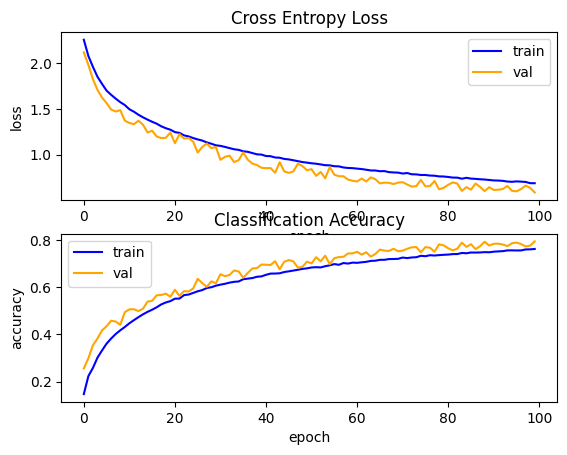

In [21]:
# The updated VGG 3 baseline model with dropout of 0.2, 0.3, 0.4, 0.5 and data augmentation
model, history = run_test_harness(epochs=100, batch_size=64)

variable dropout at each layer is not improving model performance!! it is 79.14%

### Dropout and Data Augmentation and Batch Normalization

We can expand upon the previous example in a few ways.

First, we can increase the number of training epochs from 100 to 200, to give the model more of an opportunity to improve.

Next, we can add batch normalization in an effort to stabilize the learning and perhaps accelerate the learning process. To offset this acceleration, we can increase the regularization by changing the dropout from a fixed pattern to an increasing pattern.( we will train model with both pattern fixed and variable dropout regularization)

##### Dropout(FIXED 0.2) and Data Augmentation and Batch Normalization¶

In [22]:
# The updated VGG 3 baseline model with dropout of 0.2 in each block , data augmentation and Batch Normalization
from keras.layers import BatchNormalization
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
    
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
    
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
    
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


def run_test_harness(epochs=50, batch_size=64):
    # load dataset
    trainX, trainY, valX, valY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, valX, testX = prep_pixels(trainX, valX, testX)
    
    # define model
    model = define_model()
    
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY, batch_size=batch_size)
    # fit model
#     steps = int(trainX.shape[0] / 64)
    
    history = model.fit_generator(it_train,
#                                   steps_per_epoch=steps, 
                                  epochs=epochs,
                                  validation_data=(valX, valY), 
                                  verbose=1)
    # evaluate model
    print('-'*100)
    print("Evaluation on Test Set : ")
    loss, acc = model.evaluate(testX, testY, verbose=1)
    print('Test set Loss > %.3f' % (loss * 100.0))
    print('Test set Accuracy > %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)
    return model, history

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-22-22f219fc7d9b>:56: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(it_train,


Epoch 1/200
625/625 [==============================] - 27s 42ms/step - loss: 1.9002 - accuracy: 0.3488 - val_loss: 1.4200 - val_accuracy: 0.4904
Epoch 2/200
625/625 [==============================] - 28s 44ms/step - loss: 1.5169 - accuracy: 0.4552 - val_loss: 1.2850 - val_accuracy: 0.5404
Epoch 3/200
625/625 [==============================] - 27s 43ms/step - loss: 1.3763 - accuracy: 0.5065 - val_loss: 1.5330 - val_accuracy: 0.4743
Epoch 4/200
625/625 [==============================] - 26s 41ms/step - loss: 1.2795 - accuracy: 0.5412 - val_loss: 1.3080 - val_accuracy: 0.5406
Epoch 5/200
625/625 [==============================] - 27s 43ms/step - loss: 1.2045 - accuracy: 0.5662 - val_loss: 1.2219 - val_accuracy: 0.5660
Epoch 6/200
625/625 [==============================] - 25s 41ms/step - loss: 1.1493 - accuracy: 0.5890 - val_loss: 1.1077 - val_accuracy: 0.6041
Epoch 7/200
625/625 [==============================] - 27s 43ms/step - loss: 1.0983 - accuracy: 0.6054 - val_loss: 1.1288 - val_ac

625/625 [==============================] - 27s 43ms/step - loss: 0.4152 - accuracy: 0.8529 - val_loss: 0.4608 - val_accuracy: 0.8463
Epoch 114/200
625/625 [==============================] - 26s 41ms/step - loss: 0.4168 - accuracy: 0.8537 - val_loss: 0.4909 - val_accuracy: 0.8374
Epoch 115/200
625/625 [==============================] - 26s 41ms/step - loss: 0.4108 - accuracy: 0.8561 - val_loss: 0.4379 - val_accuracy: 0.8527
Epoch 116/200
625/625 [==============================] - 26s 41ms/step - loss: 0.4136 - accuracy: 0.8547 - val_loss: 0.4220 - val_accuracy: 0.8556
Epoch 117/200
625/625 [==============================] - 27s 43ms/step - loss: 0.4107 - accuracy: 0.8575 - val_loss: 0.4495 - val_accuracy: 0.8487
Epoch 118/200
625/625 [==============================] - 26s 42ms/step - loss: 0.4072 - accuracy: 0.8576 - val_loss: 0.4418 - val_accuracy: 0.8508
Epoch 119/200
625/625 [==============================] - 26s 41ms/step - loss: 0.4045 - accuracy: 0.8600 - val_loss: 0.4369 - val_ac

Epoch 169/200
625/625 [==============================] - 27s 43ms/step - loss: 0.3307 - accuracy: 0.8834 - val_loss: 0.3947 - val_accuracy: 0.8722
Epoch 170/200
625/625 [==============================] - 26s 42ms/step - loss: 0.3263 - accuracy: 0.8844 - val_loss: 0.4055 - val_accuracy: 0.8653
Epoch 171/200
625/625 [==============================] - 27s 44ms/step - loss: 0.3339 - accuracy: 0.8815 - val_loss: 0.3725 - val_accuracy: 0.8757
Epoch 172/200
625/625 [==============================] - 26s 42ms/step - loss: 0.3228 - accuracy: 0.8857 - val_loss: 0.4098 - val_accuracy: 0.8606
Epoch 173/200
625/625 [==============================] - 27s 43ms/step - loss: 0.3277 - accuracy: 0.8849 - val_loss: 0.4067 - val_accuracy: 0.8649
Epoch 174/200
625/625 [==============================] - 27s 43ms/step - loss: 0.3233 - accuracy: 0.8843 - val_loss: 0.4031 - val_accuracy: 0.8675
Epoch 175/200
625/625 [==============================] - 27s 42ms/step - loss: 0.3205 - accuracy: 0.8877 - val_loss: 0

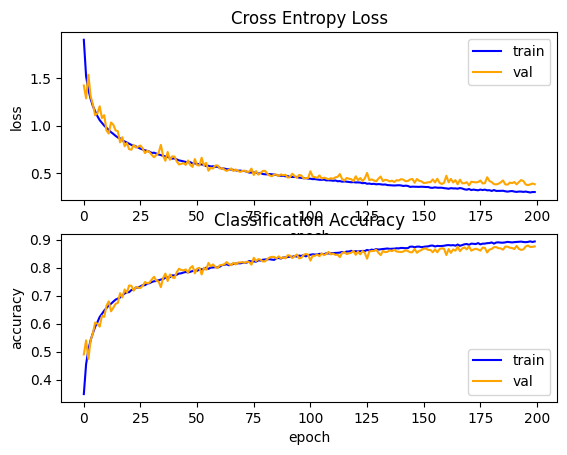

In [23]:
# The updated VGG 3 baseline model with dropout of 0.2 in each block , data augmentation and Batch Normalization
model, history = run_test_harness(epochs=200, batch_size=64)

In this case, we can see that we achieved a further lift in model performance to about 87.04% accuracy, improving upon both dropout and data augmentation alone at about 82.32% and upon the increasing dropout alone at about 80.23%.

Reviewing the learning curves, we can see the training of the model shows continued improvement for nearly the duration of 200 epochs. We can see perhaps a slight drop-off on the val dataset at around 125 epochs, but the improvement trend does continue.

##### Dropout(Variable 0.2, 0.3, 0.4, 0.5) and Data Augmentation and Batch Normalization

In [24]:
# The updated VGG 3 baseline model with variable dropout in each block , data augmentation and Batch Normalization
from keras.layers import BatchNormalization
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
    
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
    
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
    
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


def run_test_harness(epochs=50, batch_size=64):
    # load dataset
    trainX, trainY, valX, valY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, valX, testX = prep_pixels(trainX, valX, testX)
    
    # define model
    model = define_model()
    
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY, batch_size=batch_size)
    # fit model
#     steps = int(trainX.shape[0] / 64)
    
    history = model.fit_generator(it_train,
#                                   steps_per_epoch=steps, 
                                  epochs=epochs,
                                  validation_data=(valX, valY), 
                                  verbose=1)
    # evaluate model
    print('-'*100)
    print("Evaluation on Test Set : ")
    loss, acc = model.evaluate(testX, testY, verbose=1)
    print('Test set Loss > %.3f' % (loss * 100.0))
    print('Test set Accuracy > %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)
    return model, history

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-24-6c27687475b1>:56: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(it_train,


Epoch 1/200
625/625 [==============================] - 28s 44ms/step - loss: 2.2420 - accuracy: 0.2793 - val_loss: 1.7918 - val_accuracy: 0.3712
Epoch 2/200
625/625 [==============================] - 26s 41ms/step - loss: 1.6666 - accuracy: 0.3930 - val_loss: 1.4385 - val_accuracy: 0.4674
Epoch 3/200
625/625 [==============================] - 26s 42ms/step - loss: 1.5324 - accuracy: 0.4426 - val_loss: 1.3604 - val_accuracy: 0.5038
Epoch 4/200
625/625 [==============================] - 26s 41ms/step - loss: 1.4524 - accuracy: 0.4689 - val_loss: 1.3329 - val_accuracy: 0.5138
Epoch 5/200
625/625 [==============================] - 26s 41ms/step - loss: 1.3889 - accuracy: 0.4926 - val_loss: 1.3215 - val_accuracy: 0.5187
Epoch 6/200
625/625 [==============================] - 25s 40ms/step - loss: 1.3420 - accuracy: 0.5135 - val_loss: 1.7709 - val_accuracy: 0.4138
Epoch 7/200
625/625 [==============================] - 23s 36ms/step - loss: 1.2935 - accuracy: 0.5314 - val_loss: 1.2877 - val_ac

625/625 [==============================] - 27s 43ms/step - loss: 0.5600 - accuracy: 0.8087 - val_loss: 0.4751 - val_accuracy: 0.8363
Epoch 114/200
625/625 [==============================] - 25s 40ms/step - loss: 0.5562 - accuracy: 0.8112 - val_loss: 0.5594 - val_accuracy: 0.8087
Epoch 115/200
625/625 [==============================] - 23s 36ms/step - loss: 0.5527 - accuracy: 0.8097 - val_loss: 0.4831 - val_accuracy: 0.8343
Epoch 116/200
625/625 [==============================] - 26s 42ms/step - loss: 0.5450 - accuracy: 0.8127 - val_loss: 0.5342 - val_accuracy: 0.8158
Epoch 117/200
625/625 [==============================] - 26s 41ms/step - loss: 0.5435 - accuracy: 0.8138 - val_loss: 0.5552 - val_accuracy: 0.8133
Epoch 118/200
625/625 [==============================] - 26s 41ms/step - loss: 0.5418 - accuracy: 0.8133 - val_loss: 0.4934 - val_accuracy: 0.8312
Epoch 119/200
625/625 [==============================] - 27s 43ms/step - loss: 0.5389 - accuracy: 0.8170 - val_loss: 0.4969 - val_ac

Epoch 169/200
625/625 [==============================] - 26s 42ms/step - loss: 0.4634 - accuracy: 0.8402 - val_loss: 0.4415 - val_accuracy: 0.8532
Epoch 170/200
625/625 [==============================] - 27s 44ms/step - loss: 0.4589 - accuracy: 0.8437 - val_loss: 0.4367 - val_accuracy: 0.8531
Epoch 171/200
625/625 [==============================] - 26s 41ms/step - loss: 0.4622 - accuracy: 0.8416 - val_loss: 0.4131 - val_accuracy: 0.8606
Epoch 172/200
625/625 [==============================] - 27s 43ms/step - loss: 0.4583 - accuracy: 0.8420 - val_loss: 0.4256 - val_accuracy: 0.8542
Epoch 173/200
625/625 [==============================] - 26s 42ms/step - loss: 0.4523 - accuracy: 0.8435 - val_loss: 0.4426 - val_accuracy: 0.8498
Epoch 174/200
625/625 [==============================] - 27s 43ms/step - loss: 0.4545 - accuracy: 0.8435 - val_loss: 0.4587 - val_accuracy: 0.8471
Epoch 175/200
625/625 [==============================] - 26s 41ms/step - loss: 0.4545 - accuracy: 0.8446 - val_loss: 0

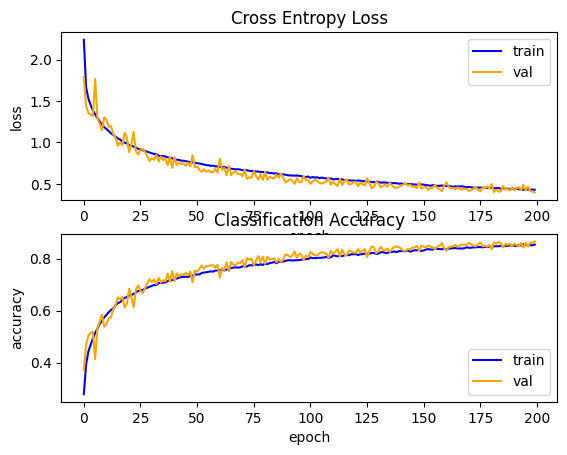

In [25]:
# The updated VGG 3 baseline model with variable dropout in each block , data augmentation and Batch Normalization
model, history = run_test_harness(epochs=200, batch_size=64)

## Summary
In this section, we explored two approaches designed to expand upon changes to the model that we know already result in an improvement

for(50 epochs)
- Baseline : 70.2%
- Baseline + same Dropout(0.2): 80.23%
- Baseline + Weight Decay(0.001): 70.9%
- Baseline + Weight Decay(0.01): 72.66%
- Baseline + Weight Decay(0.1): 33.08%
- Baseline + Data Augmentation: 78.9%

A summary of the results is provided below:
#### Baseline + Increasing Dropout: 70.9% (50 epochs)
#### Baseline + same Dropout + Data Augmentation: 82.32.880%  (100 epochs)
#### Baseline + Increasing Dropout + Data Augmentation: 79.14%  (100 epochs)
#### Baseline + same Dropout + Data Augmentation + Batch Normalization: 87.04%   (200 epochs)
#### Baseline + Increasing Dropout + Data Augmentation + Batch Normalization: 86.10%  (200 epochs)

The model is now learning well and we have good control over the rate of learning without overfitting.
We might be able to achieve further improvements with additional regularization. This could be achieved with more aggressive dropout in later layers. It is possible that further addition of weight decay may improve the model.

So far, we have not tuned the hyperparameters of the learning algorithm, such as the learning rate, which is perhaps the most important hyperparameter. We may expect further improvements with adaptive changes to the learning rate, such as use of an adaptive learning rate technique such as Adam. These types of changes may help to refine the model once converged.

In [27]:
model.save('Saved_model/CIFAR10_final_model.h5')

In [36]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img


img = load_image('car.jpeg')
result = model.predict(img)
np.argmax(result, axis=1)

array([1])

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Val: X=(10000, 32, 32, 3), y=(10000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


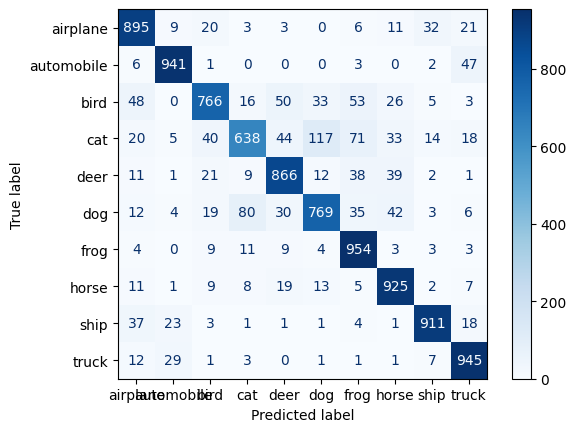

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# load dataset
trainX, trainY, valX, valY, testX, testY = load_dataset()
# prepare pixel data
trainX, valX, testX = prep_pixels(trainX, valX, testX)
    
predY=model.predict(testX)

test_Y = np.argmax(testY, axis=1)
pred_Y = np.argmax(predY, axis=1)

cm = confusion_matrix(test_Y, pred_Y)

CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [43]:
from sklearn.metrics import classification_report
print(classification_report(test_Y, pred_Y, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    airplane       0.85      0.90      0.87      1000
  automobile       0.93      0.94      0.93      1000
        bird       0.86      0.77      0.81      1000
         cat       0.83      0.64      0.72      1000
        deer       0.85      0.87      0.86      1000
         dog       0.81      0.77      0.79      1000
        frog       0.82      0.95      0.88      1000
       horse       0.86      0.93      0.89      1000
        ship       0.93      0.91      0.92      1000
       truck       0.88      0.94      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## 5.Extensions

we can improve model peformance by trying below :

**Pixel Scaling**. Explore alternate techniques for scaling the pixels, such as centering and standardization, and compare performance.

**Learning Rates**. Explore alternate learning rates, adaptive learning rates, and learning rate schedules and compare performance.

**Transfer Learning**. Explore using transfer learning, such as a pre-trained VGG-16 model on this dataset.

In [4]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.5 MB 644 kB/s eta 0:00:01
     |████████████████████████████████| 503 kB 15.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

def process(image):
    image = tf.cast(image/255. ,tf.float32)
    return image


train_dataset = image_dataset_from_directory(
    "/home/tensorflow/Documents/Downloads/test",
    labels=None,
    batch_size=3000,
    image_size=(32, 32),
    shuffle=False,    
)

from tensorflow import keras
model = keras.models.load_model('Saved_model/CIFAR10_final_model.h5')

print(train_dataset)
# dataset_test = dataset_test.map(process)
new_d = train_dataset.map(process) 

predY=model.predict_generator(new_d)

Found 300000 files belonging to 1 classes.
<BatchDataset shapes: (None, 32, 32, 3), types: tf.float32>


<ipython-input-12-225fc55b47f2>:24: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predY=model.predict_generator(new_d)


In [13]:
file_paths = train_dataset.file_paths
len(file_paths)

300000

In [26]:
# tf.keras.backend.clear_session()
import pandas as pd
import numpy as np
pred_Y = np.argmax(predY, axis=1)
img_ids = pd.Series(train_dataset.file_paths).map(lambda x : int(x.split("/")[-1].split(".")[0]))


In [32]:
d = pd.DataFrame({"id": img_ids })
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
d['label']= pd.Series(pred_Y).map(lambda x : CLASS_NAMES[x])
d = d.sort_values(by = "id")
d.to_csv("kaggle_submission.csv", index=False)                        

In [33]:
!wc -l kaggle_submission.csv

# https://www.kaggle.com/c/cifar-10/data?select=sampleSubmission.csv

300001 kaggle_submission.csv


In [35]:
d.head()

,id,label
0,1,truck
111111,2,bird
222222,3,automobile
233334,4,ship
244445,5,airplane


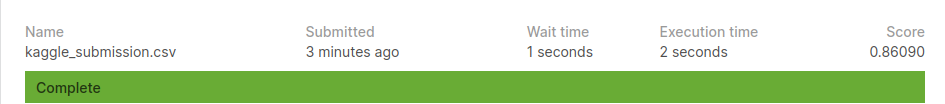

In [ ]:
# https://www.kaggle.com/c/cifar-10/overview